In [1]:
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
import optuna
from joblib import Parallel, delayed
from utils.Loader import NEUDataset
from utils.Perspectiver import Perspectiver
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import multiprocessing
import torch
from mpl_toolkits.mplot3d import Axes3D
from skimage.restoration import denoise_wavelet
import random
import math
from PIL import Image
from collections import deque
import numpy as np
from scipy.ndimage import maximum_filter, minimum_filter, label, generate_binary_structure
from concurrent.futures import ProcessPoolExecutor, as_completed
from scipy.ndimage import label as ndi_label, binary_dilation

/home/lingfeng/Desktop/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def move(initial_pos, direction): return tuple(a + b for a, b in zip(initial_pos, direction))

def _get_area_groups(walker, positions:set, directions, record: set):
    next_moves = set()
    for dir in directions:
        next_pos = move(walker,directions[dir])
        if ( (next_pos in positions) and (next_pos not in (record)) ) :
            record.add(next_pos)
            next_moves.add(next_pos)
    if len(next_moves) == 0:
        record.add(walker)
    for next in next_moves:
        #print(next)
        walker = next
        record = record | _get_area_groups(walker, positions, directions, record)
    return record

def get_pits (cluster, maxcol: int, maxrow: int, previus_pits, previus_hills):
    pits = previus_pits
    hills = previus_hills
    directions={"right": (1,0), "left": (-1,0), "down":(0,1), "up":(0,-1)}
    #print(f"Tamaño: {len(cluster)}")
    while len(cluster) != 0:

        walker = cluster[0]
        #print(f"walker: {(walker)}")
        group  = _get_area_groups(walker=walker, positions=cluster, directions=directions, record=set())
        isValid = True

        for coordinate in group:
            if ( (0 in coordinate) or 
                 ( (maxrow-1) == np.array(coordinate)[0] ) or
                 ( (maxcol-1) == np.array(coordinate)[1] ) ): #Border cluster
                isValid=False
                break
            else: #Hay que comprobar que no es vecino fosas anteriormente reconocidas
                if previus_pits is not None:
                    for prev_pit in previus_pits:
                        for dir in directions:
                            if move(coordinate, directions[dir]) in prev_pit: 
                                isValid=False
                                break
                elif previus_hills is not None:
                    for prev_hill in previus_hills:
                        for dir in directions:
                            if move(coordinate, directions[dir]) in prev_hill: 
                                isValid=False
                                break

        #print(f"Tamaño antes de quitar un area: {len(cluster)}")
        cluster = [x for x in cluster if x not in group]

        #print(f"Tamaño despues: {len(cluster)}")
        if isValid: pits.append(group)
        else: hills.append(group)
        #print(pits)
    return pits, hills
            
def get_mean_pit_area(image):
    pixels = np.uint8(np.round(Perspectiver.rgb_to_grayscale(Perspectiver.normalize_to_uint8(image))))
    #pixels = image
    clusters = np.sort(np.unique(pixels))
    #print(f"Formato de la imagen: {image.shape}, clusters : {clusters}")

    pits = []
    hills = []

    MAXROW, MAXCOL = pixels.shape
    for cluster in clusters:

        #print(f"Altura del cluster: {cluster}")
        
        rows, cols = np.where(pixels == cluster)

        positions = list(zip(rows, cols))

        pits, hills = get_pits(positions, maxcol=MAXCOL, maxrow=MAXROW, previus_pits=pits, previus_hills=hills)

    area = sum([len(pit) for pit in pits])
    return area/len(pits)

In [3]:
import cv2
import numpy as np

def get_mean_pit_area_superfast(image):
    """
    Procesa de manera determinista los grupos conectados, 
    ordenándolos de abajo hacia arriba (fila descendente) 
    y columna ascendente.
    """
    # Convertimos la imagen a escala de grises normalizada
    pixels = np.uint8(
        np.round(
            Perspectiver.rgb_to_grayscale(
                Perspectiver.normalize_to_uint8(image)
            )
        )
    )

    maxrow, maxcol = pixels.shape
    clusters = np.sort(np.unique(pixels))

    pits, hills = [], []
    pits_union, hills_union = set(), set()

    # Direcciones para comprobar contigüidad y adyacencia
    directions = [(1,0), (-1,0), (0,1), (0,-1)]

    # Recolectamos todos los grupos conectados
    all_groups = []
    for cluster in clusters:
        mask = (pixels == cluster).astype(np.uint8)
        nlabels, labels = cv2.connectedComponents(mask, connectivity=4)

        for lbl_idx in range(1, nlabels):
            coords = np.argwhere(labels == lbl_idx)
            group_set = set(map(tuple, coords))
            # Coordenada mínima de la región (en filas y columnas)
            min_coord = coords.min(axis=0)  # (min_row, min_col)
            
            # Guardamos (min_coord, set_de_pixeles, cluster) 
            all_groups.append((tuple(min_coord), group_set, cluster))

    # Ahora ordenamos de ABAJO hacia ARRIBA => 
    # orden por -min_row. Para columnas, a menudo se deja en ascendente.
    # Cambiar a -min_col si se desea invertir también la columna.
    all_groups.sort(key=lambda x: (-x[0][0], x[0][1]))

    # Clasificación determinista de cada grupo (pits o hills)
    for _, group_set, _ in all_groups:
        is_valid = True
        for (gx, gy) in group_set:
            # Si toca borde, es hill
            if gx == 0 or gx == (maxrow - 1) or gy == 0 or gy == (maxcol - 1):
                is_valid = False
                break
            # Si está adyacente a grupos ya clasificados
            for dx, dy in directions:
                nx, ny = gx + dx, gy + dy
                if (nx, ny) in pits_union or (nx, ny) in hills_union:
                    is_valid = False
                    break
            if not is_valid:
                break

        # Asignamos según resultado
        if is_valid:
            pits.append(group_set)
            pits_union.update(group_set)
        else:
            hills.append(group_set)
            hills_union.update(group_set)

    # Área promedio de fosas
    if len(pits) == 0:
        return 0
    total_area = sum(len(p) for p in pits)
    return total_area / len(pits)


In [4]:
dataset = NEUDataset(set="train", transform=None, seed=1, scale=0.5)

# Probar con un DataLoader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Intentar iterar sobre el dataloader
for images, labels in dataloader:
    print("Iteración exitosa.")
    print("Imagen shape:", images.shape)
    print("Etiqueta shape:", labels.shape)
    break 

Iteración exitosa.
Imagen shape: torch.Size([4, 1, 100, 100])
Etiqueta shape: torch.Size([4, 6])


In [5]:
image, label = dataset.__getitem__(index=random.randint(2, len(dataset)))

'''
image = Image.open("metal_dataset/test/Pitted/PS_108.bmp")
original_width, original_height = image.size
scale = 0.5
image = image.resize((max(1, int(original_width * scale)), max(1, int(original_height * scale))))
original_image = Perspectiver.grayscale_to_rgb(Perspectiver.normalize_to_uint8(np.array(image)))
'''
original_image = Perspectiver.grayscale_to_rgb(Perspectiver.normalize_to_uint8(image.detach().cpu().numpy()[0]))

In [6]:
image = Image.open("metal_dataset/valid/Scratches/Sc_111.bmp")
original_width, original_height = image.size
scale = 0.5
image = image.resize((max(1, int(original_width * scale)), max(1, int(original_height * scale))))
original_image = Perspectiver.grayscale_to_rgb(Perspectiver.normalize_to_uint8(np.array(image)))

In [7]:
def optimize_image(image, n_tries: int = 100 , min_k = 2):
    """
    Optimizes the mean shift parameters to maximize the metric: (Silhouette Score / Number of Clusters).

    Args:
        image (np.array): The input image with shape (200, 200, 3).
        n_tries (int): The number of optimization trials to run.

    Returns:
        dict: The best parameters and the best score.
    """

    # Define the objective function for Optuna
    def objective(trial):
        # Suggest parameters for spatial radius and color radius
        sp = trial.suggest_float("sp", 1.0, 50.0)  # Spatial window radius
        sr = trial.suggest_float("sr", 1.0, 50.0)  # Color window radius
        k = trial.suggest_int("k", min_k, 30)
        # Apply mean shift filtering
        after = Perspectiver.kmeansClustering(Perspectiver.meanShift(image, sp, sr), k=k)

        return get_mean_pit_area_superfast(after)

    # Determine the number of CPU threads
    n_jobs = multiprocessing.cpu_count()-2
    print(f"Using {n_jobs} CPU threads for parallel optimization.")

    # Run the optimization with parallel trials
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_tries, n_jobs=n_jobs)

    # Return the best parameters and the best score
    return {
        "best_params": study.best_params,
        "best_score": study.best_value
    }

In [8]:
def plot_barchartImage(image):
    x = np.arange(image.shape[0])
    y = np.arange(image.shape[1])
    x, y = np.meshgrid(x, y)

    # Flatten arrays for plotting
    x = x.flatten()
    y = y.flatten()
    z = np.zeros_like(x)
    dx = dy = np.ones_like(x)
    dz = image.flatten()

    # Plot the 3D bar chart
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.bar3d(x, y, z, dx, dy, dz, shade=True)

    # Add labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Value')
    ax.set_title('3D Bar Chart of (200, 200) Array')

    plt.show()

In [9]:
BEST = optimize_image(original_image, n_tries=800)["best_params"]
BEST

[I 2025-02-05 20:31:42,152] A new study created in memory with name: no-name-664d3854-25e2-4f2e-a175-36aaa197bbcb
[I 2025-02-05 20:31:42,234] Trial 1 finished with value: 12.0 and parameters: {'sp': 5.3736421037166995, 'sr': 41.75867538671085, 'k': 3}. Best is trial 1 with value: 12.0.
[I 2025-02-05 20:31:42,257] Trial 5 finished with value: 5.0 and parameters: {'sp': 17.262324610683418, 'sr': 37.28864773400472, 'k': 2}. Best is trial 1 with value: 12.0.


Using 6 CPU threads for parallel optimization.


[I 2025-02-05 20:31:42,318] Trial 0 finished with value: 2.340909090909091 and parameters: {'sp': 10.394574607183646, 'sr': 46.52759633023926, 'k': 9}. Best is trial 1 with value: 12.0.
[I 2025-02-05 20:31:42,500] Trial 7 finished with value: 4.7 and parameters: {'sp': 4.482501610193451, 'sr': 39.01396536586366, 'k': 7}. Best is trial 1 with value: 12.0.
[I 2025-02-05 20:31:42,657] Trial 9 finished with value: 5.421052631578948 and parameters: {'sp': 20.159265178413445, 'sr': 45.202163383175694, 'k': 4}. Best is trial 1 with value: 12.0.
[I 2025-02-05 20:31:42,698] Trial 6 finished with value: 3.452830188679245 and parameters: {'sp': 38.97330377733058, 'sr': 46.298189055472335, 'k': 12}. Best is trial 1 with value: 12.0.
[I 2025-02-05 20:31:42,862] Trial 3 finished with value: 1.8495297805642634 and parameters: {'sp': 8.259288094081743, 'sr': 3.644093079278742, 'k': 29}. Best is trial 1 with value: 12.0.
[I 2025-02-05 20:31:42,936] Trial 4 finished with value: 2.036036036036036 and par

{'sp': 30.12451379550981, 'sr': 48.27539040714869, 'k': 2}

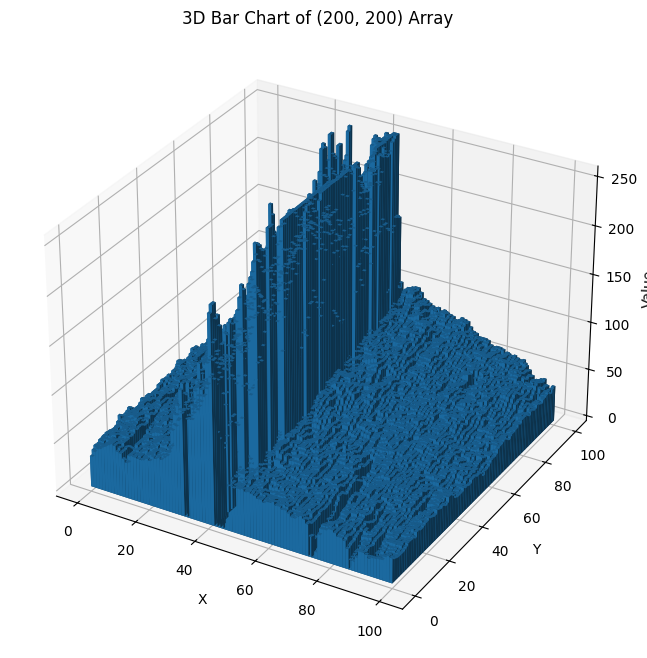

In [10]:
plot_barchartImage(Perspectiver.rgb_to_grayscale(original_image))

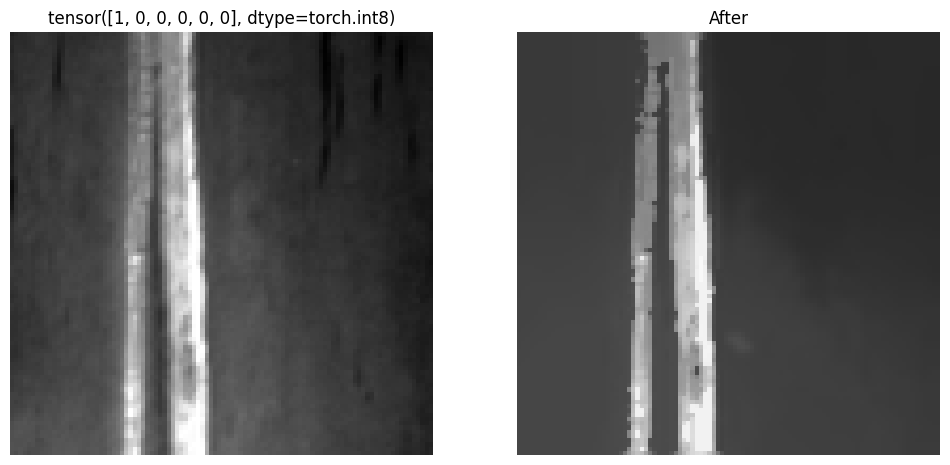

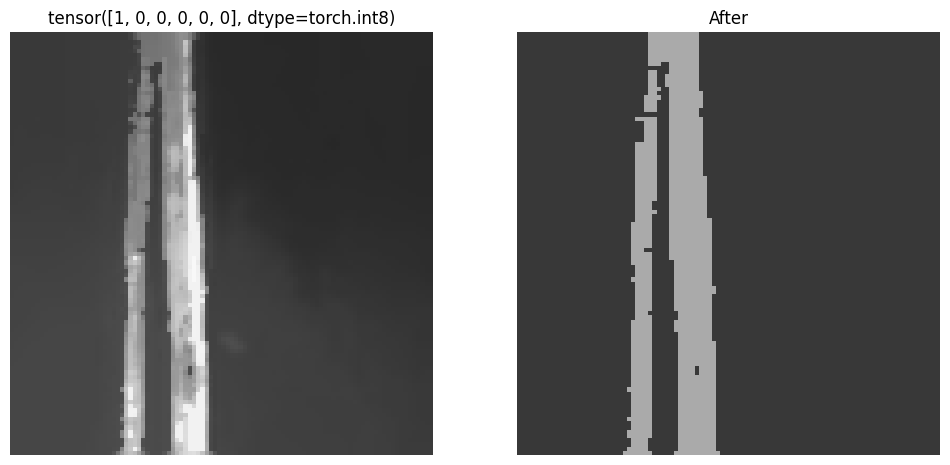

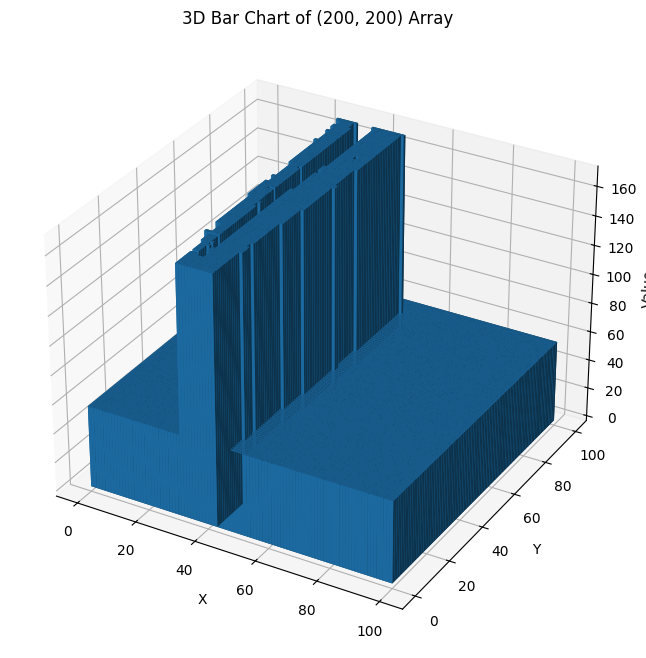

Real mean : 14.0
Optimized : 14.0


In [11]:
clustered_image = Perspectiver.meanShift(original_image, BEST["sp"], BEST["sr"])
#clustered_image = Perspectiver.meanShift(original_image, 5, 6)
Perspectiver.plotComparison(original_image, clustered_image, titleBefore=label)

kmeans_image = Perspectiver.kmeansClustering(clustered_image, k = BEST["k"])
#kmeans_image = Perspectiver.kmeansClustering(clustered_image, k = 7)
Perspectiver.plotComparison(clustered_image, kmeans_image, titleBefore=label)

plot_barchartImage(Perspectiver.rgb_to_grayscale(kmeans_image))
Perspectiver.evaluate_clustering(original_image, kmeans_image)
print("Real mean :", get_mean_pit_area(kmeans_image))
print("Optimized :", get_mean_pit_area_superfast(kmeans_image))

In [12]:
import csv

def create_register(dataset, output_file="output.csv"):
    """
    Genera un archivo CSV con Path, sp, sr, k, optimized_score y real_score.
    """
    # Cabecera del CSV
    header = ["Path", "sp", "sr", "k", "optimized_score", "real_score"]
    
    with open(output_file, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(header)
        
        for i in range(len(dataset)):
            image, label = dataset.__getitem__(index=i)
            original_image = Perspectiver.grayscale_to_rgb(
                Perspectiver.normalize_to_uint8(
                    image.detach().cpu().numpy()[0]
                )
            )
            
            BEST = optimize_image(original_image, n_tries=800, min_k=2)
            BEST_PARAM = BEST["best_params"]
            BEST_SCORE = BEST["best_score"]
            
            path = dataset.data["Path"][i]
            sp = BEST_PARAM["sp"]
            sr = BEST_PARAM["sr"]
            k = BEST_PARAM["k"]
            optimized_score = BEST_SCORE
            real_score = get_mean_pit_area(original_image)
            
            # Escribe cada fila con los datos
            writer.writerow([path, sp, sr, k, optimized_score, real_score])
            
            break
create_register(dataset)

[I 2025-02-05 20:32:35,217] A new study created in memory with name: no-name-7357341a-909c-48dc-a23a-a660e8fcd10a
[I 2025-02-05 20:32:35,267] Trial 0 finished with value: 2.5714285714285716 and parameters: {'sp': 1.3685370251934255, 'sr': 23.65073993682198, 'k': 2}. Best is trial 0 with value: 2.5714285714285716.


Using 6 CPU threads for parallel optimization.


[I 2025-02-05 20:32:35,512] Trial 1 finished with value: 2.193548387096774 and parameters: {'sp': 9.12889557017924, 'sr': 28.686844635295696, 'k': 17}. Best is trial 0 with value: 2.5714285714285716.
[I 2025-02-05 20:32:35,669] Trial 2 finished with value: 1.9038461538461537 and parameters: {'sp': 8.72156234275629, 'sr': 17.84260264716114, 'k': 29}. Best is trial 0 with value: 2.5714285714285716.
[I 2025-02-05 20:32:35,848] Trial 8 finished with value: 2.142857142857143 and parameters: {'sp': 26.764655240128647, 'sr': 38.63214206365493, 'k': 2}. Best is trial 0 with value: 2.5714285714285716.
[I 2025-02-05 20:32:35,864] Trial 5 finished with value: 2.823529411764706 and parameters: {'sp': 2.568860063115744, 'sr': 43.015855766089054, 'k': 27}. Best is trial 5 with value: 2.823529411764706.
[I 2025-02-05 20:32:36,039] Trial 3 finished with value: 3.1338582677165356 and parameters: {'sp': 44.687926594529145, 'sr': 33.21834589188909, 'k': 28}. Best is trial 3 with value: 3.1338582677165356